# Extending modAL
modAL was designed for researchers, allowing quick and efficient prototyping. For this purpose, modAL makes it easy for you to use your customly designed parts, for instance query strategies or new classifier algorithms.

## Building blocks of query strategies

In modAL, a query strategy for active learning is implemented as a function, taking an estimator and a bunch of data, turning it into an instance from the data you supplied to it. To build elaborate custom query strategies, many building blocks are available. The two main components of a query strategy are the utility measure and the query selector. From an abstract viewpoint, this is how a query strategy looks like.

In [1]:
def custom_query_strategy(classifier, X, a_keyword_argument=42):
    # measure the utility of each instance in the pool
    utility = utility_measure(classifier, X)

    # select the indices of the instances to be queried
    query_idx = select_instances(utility)

    # return the indices and the instances
    return query_idx, X[query_idx]

To demonstrate how can you create new query strategies, first we create a toy dataset.

In [2]:
import numpy as np
from sklearn.datasets import make_blobs

# generating the data
centers = np.asarray([[-2, 3], [0.5, 5], [1, 1.5]])
X, y = make_blobs(
    n_features=2, n_samples=1000, random_state=0, cluster_std=0.7,
    centers=centers
)

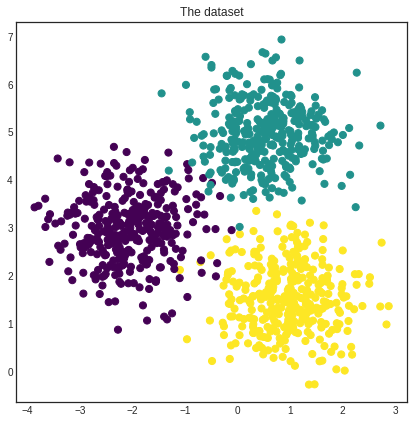

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# visualizing the dataset
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(7, 7))
    plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap='viridis', s=50)
    plt.title('The dataset')
    plt.show()

In [4]:
# initial training data
initial_idx = np.random.choice(range(len(X)), size=20)
X_training, y_training = X[initial_idx], y[initial_idx]

Finally, we initialize an ActiveLearner instance which we will use to demonstrate our custom query strategies.

In [5]:
from modAL.models import ActiveLearner
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# initializing the learner
learner = ActiveLearner(
    estimator=GaussianProcessClassifier(1.0 * RBF(1.0)),
    X_training=X_training, y_training=y_training
)

## Utility measures<a name="utility-measures"></a>
The soul of a query strategy is the utility measure. A utility measure takes a pool of examples (and frequently but optionally an estimator object) and returns a one dimensional array containing the utility score for each example. For instance, ```classifier_uncertainty```, ```classifier_margin``` and ```classifier_entropy``` from ```modAL.uncertainty``` are utility measures which you can use. You can also implement your own or you can take linear combinations and products, as we shall see next.

## Linear combinations and products<a name="combinators"></a>
One way of creating new utility measures is to take linear combinations or products of already existing ones. For this, the function factories in the module ```modAL.utils.combination``` are there to help!

In [6]:
from modAL.utils.combination import make_linear_combination, make_product
from modAL.uncertainty import classifier_uncertainty, classifier_margin

# creating new utility measures by linear combination and product
# linear_combination will return 1.0*classifier_uncertainty + 1.0*classifier_margin
linear_combination = make_linear_combination(
    classifier_uncertainty, classifier_margin,
    weights=[1.0, 1.0]
)
# product will return (classifier_uncertainty**0.5)*(classifier_margin**0.1)
product = make_product(
    classifier_uncertainty, classifier_margin,
    exponents=[0.5, 0.1]
)

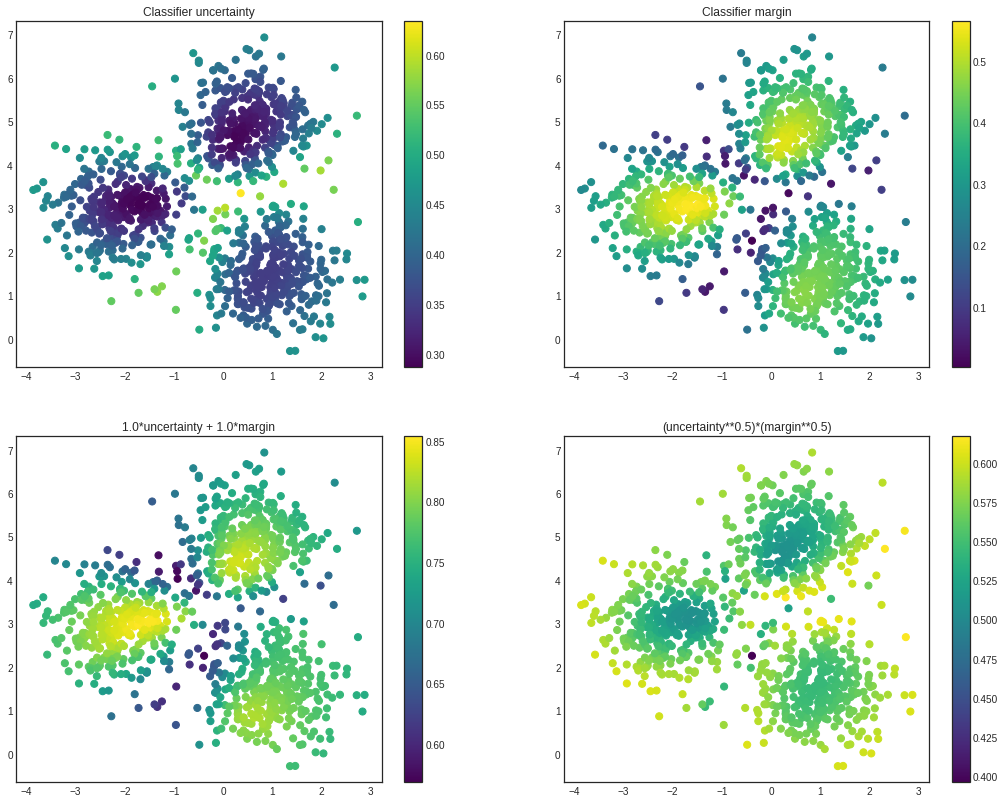

In [7]:
# visualizing the different utility metrics
with plt.style.context('seaborn-white'):
    utilities = [
        (1, classifier_uncertainty(learner, X), 'Classifier uncertainty'),
        (2, classifier_margin(learner, X), 'Classifier margin'),
        (3, linear_combination(learner, X), '1.0*uncertainty + 1.0*margin'),
        (4, product(learner, X), '(uncertainty**0.5)*(margin**0.5)')
    ]

    plt.figure(figsize=(18, 14))
    for idx, utility, title in utilities:
        plt.subplot(2, 2, idx)
        plt.scatter(x=X[:, 0], y=X[:, 1], c=utility, cmap='viridis', s=50)
        plt.title(title)
        plt.colorbar()

    plt.show()

## Selectors<a name="selectors"></a>
After the individual utility scores are calculated, a query strategy must determine which instances are to be queried. Two prebuilt selectors are available in ```modAL.utils.selection```: ```multi_argmax(values, n_instances=1)``` selects the ```n_instances``` highest utility score, while ```weighted_random(weights, n_instances=1)``` selects the instances by random, using the supplied weighting.

## Putting them together<a name="putting-them-together"></a>
When the components are given, putting the query strategy together is really simple.

In [8]:
from modAL.utils.selection import multi_argmax

# defining the custom query strategy, which uses the linear combination of
# classifier uncertainty and classifier margin
def custom_query_strategy(classifier, X, n_instances=1):
    utility = linear_combination(classifier, X)
    query_idx = multi_argmax(utility, n_instances=n_instances)
    return query_idx, X[query_idx]

custom_query_learner = ActiveLearner(
    estimator=GaussianProcessClassifier(1.0 * RBF(1.0)),
    query_strategy=custom_query_strategy,
    X_training=X_training, y_training=y_training
)

In [9]:
# pool-based sampling
n_queries = 20
for idx in range(n_queries):
    query_idx, query_instance = custom_query_learner.query(X, n_instances=2)
    custom_query_learner.teach(
        X=X[query_idx].reshape(-1, 2),
        y=y[query_idx].reshape(-1, )
    )

This can be used immediately in the active learning workflow!

## Using your custom estimators<a name="custom-estimators"></a>
As long as your classifier follows the scikit-learn API, you can use it in your modAL workflow. (Really, all it needs is a ```.fit(X, y)``` and a ```.predict(X)``` method.) For instance, the ensemble model implemented in Committee can be given to an ActiveLearner.

In [10]:
from modAL.models import Committee

# initializing the learners
n_learners = 3
learner_list = []
for _ in range(n_learners):
    learner = ActiveLearner(
        estimator=GaussianProcessClassifier(1.0 * RBF(1.0)),
        X_training=X_training, y_training=y_training,
        bootstrap_init=True
    )
    learner_list.append(learner)

# assembling the Committee
committee = Committee(learner_list)

# ensemble active learner from the Committee
ensemble_learner = ActiveLearner(
    estimator=committee
)